<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Feature Engineering - Other Datasets<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

This work is part of a series of notebooks starting with 01_EDA_application.

In the previous notebooks, we **performed an EDA on the application data and some of the other dataframes**, and developped a **feature engineering on the application data**.

**Here we will improve our results through more feature engineering**.

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
import re

import utils
import EDA
import feat_eng
import pipelines
import model_select

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint, uniform, mode
from lightgbm import LGBMClassifier


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

%load_ext blackcellmagic

<h1 style="color:#774CAD">Feature Engineering - Previous Applications and Installments</h1>

Some of the ideas behind the feature engineering here were already explored in the previous EDA.

To summarize, for the **previous application** we will compute, for each client,:
- the quantity of previous applications,
- the quantity of rejected/accepted/cancelled/unused_offer applications,
- Aggregate the "RATE_DOWN_PAYMENT" for each client into "median", "max", "min".

In the **Installments dataframe**, we will generate:
- the ratio of paid value by installment value (aggregates),
- flag if client ever paid less,
- delayed days of a payment (aggregates),
- flag if a client has delayed a payment.
- delayed days of a payment in the first year of application (365 days)

**These Transformers are also part of the file feat_eng.py**.

In [3]:
df_train = utils.load_df(file_path="data/df_train.csv")
col_info = utils.load_df(file_path="data/home-credit-default-risk/HomeCredit_columns_description.csv", encoding='unicode_escape')

df_previous = utils.load_df(file_path="data/home-credit-default-risk/previous_application.csv")
df_installments = utils.load_df(file_path="data/home-credit-default-risk/installments_payments.csv")

The shape of the data is: (153755, 122)
load_df took 2.882 seconds

The shape of the data is: (219, 5)
load_df took 0.018 seconds

The shape of the data is: (1670214, 37)
load_df took 9.161 seconds

The shape of the data is: (13605401, 8)
load_df took 19.890 seconds



We created only 1 complete transformer for the previous application, and one for the installment data, because the resulting dataframe represents 1 row per client id, not 1 row per application/month. These transformer, have individual functions that will be doing the specific tasks decribed above.

Let's apply both transformers and check for a description to see if we get expected values.

In [4]:
df_previous_transf = feat_eng.PreviousApplicationTransformer().fit_transform(df_previous)
df_previous_transf.head(3)

,SK_ID_CURR,PREV_previous_loan_counts,PREV_name_contract_approved,PREV_name_contract_canceled,PREV_name_contract_refused,PREV_name_contract_unused_offer,PREV_rate_down_payment_median,PREV_rate_down_payment_mean,PREV_rate_down_payment_max,PREV_rate_down_payment_min
0,100001,1,1.000,NaN,NaN,NaN,0.104,0.104,0.104,0.104
1,100002,1,1.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000
2,100003,3,3.000,NaN,NaN,NaN,0.050,0.050,0.100,0.000


The values above are as expected.

In [5]:
df_installments_transf = feat_eng.InstallmentsTransformer().fit_transform(df_installments)
df_installments_transf.head()

,SK_ID_CURR,INST_amt_payment_installment_ratio_median,INST_amt_payment_installment_ratio_mean,INST_amt_payment_installment_ratio_max,INST_amt_payment_installment_ratio_min,INST_paid_less_flag_mode,INST_paid_less_flag_any,INST_delayed_days_median,INST_delayed_days_mean,INST_delayed_days_max,INST_delayed_days_min,INST_delayed_payment_flag_mode,INST_delayed_payment_flag_any,INST_delayed_days_365_median,INST_delayed_days_365_mean,INST_delayed_days_365_max,INST_delayed_days_365_min
0,100001,1.000,1.000,1.000,1.000,0,0,6.000,7.286,36.000,-11.000,1,1,NaN,NaN,NaN,NaN
1,100002,1.000,1.000,1.000,1.000,0,0,19.000,20.421,31.000,12.000,1,1,18.000,17.364,24.000,12.000
2,100003,1.000,1.000,1.000,1.000,0,0,6.000,7.160,14.000,1.000,1,1,NaN,NaN,NaN,NaN
3,100004,1.000,1.000,1.000,1.000,0,0,9.000,7.667,11.000,3.000,1,1,NaN,NaN,NaN,NaN
4,100005,1.000,1.000,1.000,1.000,0,0,29.000,23.556,37.000,-1.000,1,1,NaN,NaN,NaN,NaN


In [6]:
df_installments_transf.describe()

,SK_ID_CURR,INST_amt_payment_installment_ratio_median,INST_amt_payment_installment_ratio_mean,INST_amt_payment_installment_ratio_max,INST_amt_payment_installment_ratio_min,INST_paid_less_flag_mode,INST_paid_less_flag_any,INST_delayed_days_median,INST_delayed_days_mean,INST_delayed_days_max,INST_delayed_days_min,INST_delayed_payment_flag_mode,INST_delayed_payment_flag_any,INST_delayed_days_365_median,INST_delayed_days_365_mean,INST_delayed_days_365_max,INST_delayed_days_365_min
count,339587.000,339575.000,339575.000,339575.000,339575.000,339587.000,339587.000,339578.000,339578.000,339578.000,339578.000,339587.000,339587.000,250823.000,250823.000,250823.000,250823.000
mean,278154.892,1.001,1.360,13.295,0.597,0.009,0.427,9.681,11.258,37.944,-15.695,0.886,0.997,8.187,9.409,23.765,-1.039
std,102880.493,0.040,28.429,839.693,0.472,0.093,0.495,11.015,12.977,28.864,108.718,0.318,0.053,38.040,38.124,38.407,68.223
min,100001.000,0.017,0.333,0.512,0.000,0.000,0.000,-2135.500,-1884.205,-42.000,-2884.000,0.000,0.000,-2882.000,-2882.000,-2882.000,-2884.000
25%,189042.500,1.000,0.955,1.000,0.015,0.000,0.000,3.000,5.889,23.000,-9.000,1.000,1.000,1.000,4.111,13.000,-1.000
50%,278238.000,1.000,1.000,1.000,1.000,0.000,0.000,8.000,9.564,31.000,-1.000,1.000,1.000,6.500,8.125,21.000,0.000
75%,367315.500,1.000,1.000,1.000,1.000,0.000,1.000,13.000,14.846,43.000,2.000,1.000,1.000,13.000,13.778,31.000,6.000
max,456255.000,2.821,8482.446,194250.000,1.970,1.000,1.000,310.000,295.000,3189.000,156.000,1.000,1.000,325.000,325.000,334.000,325.000


Here, the values also seem to be expected, most of the clients paid their installments to the fullest and there are some people who sometimes did not fully pay the installments. 

Delayed payments are obviously more often than people not fully paying the installment.

<h2 style="color:#774CAD">Pipelines and Model Run</h2>

We can now merge the recently created features to our application dataset. For that we define the next function which will also apply the feature_eng and preprocess pipeline on our data.

In [7]:
def preprocess_data(df, df_previous_transf, df_installments_transf):
    
    df_transformed = df.merge(df_previous_transf, on="SK_ID_CURR", how="left").merge(
        df_installments_transf, on="SK_ID_CURR", how="left"
    )

    X = df_transformed.drop(["TARGET", "SK_ID_CURR"], axis=1)
    y = df_transformed["TARGET"]

    feat_eng_pipe2 = Pipeline(
    steps=[
        ("drop_mode_avg", feat_eng.DropModeAVG()),
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
        ('ext_sources_transformer', feat_eng.ExternalSourcesTransformer()),
        ('financial_ratio_transformer', feat_eng.FinancialRatioTransformer()),
        ('age_employment_transformer', feat_eng.AgeAndEmploymentTransformer()),
        ]
    )

    X_FE = feat_eng_pipe2.fit_transform(X)
    num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_FE)

    preprocess_pipe = pipelines.create_preprocess_pipeline(
        num_feats, binary_feats, highcard_feats
    )
    X_ready = preprocess_pipe.fit_transform(X_FE)
    X_ready = X_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

    return X_ready, y

In [8]:
X_train, y_train = preprocess_data(
    df=df_train,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
)
print(X_train.shape, y_train.size)
X_train.head(3)

(153755, 203) 153755


,num__CNT_CHILDREN,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__DAYS_ID_PUBLISH,...,cat__ORGANIZATION_TYPE_Grouped_Industry_type,cat__ORGANIZATION_TYPE_Grouped_Kindergarten,cat__ORGANIZATION_TYPE_Grouped_Medicine,cat__ORGANIZATION_TYPE_Grouped_Other,cat__ORGANIZATION_TYPE_Grouped_Rare,cat__ORGANIZATION_TYPE_Grouped_School,cat__ORGANIZATION_TYPE_Grouped_Self_employed,cat__ORGANIZATION_TYPE_Grouped_Trade_type,cat__ORGANIZATION_TYPE_Grouped_Transport_type,cat__ORGANIZATION_TYPE_Grouped_XNA
0,0.000,-1.150,-0.618,-0.878,-0.612,-0.034,-0.969,-0.244,-0.605,-0.728,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.100,1.246,0.545,1.082,1.467,0.012,-0.179,-0.522,0.940,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,1.000,-0.400,1.918,0.885,2.041,-0.003,-0.368,0.441,-0.036,-0.782,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<h2 style="color:#774CAD">Applying to Model</h2>

In [9]:
def randomized_search_LGBM(X, y, param_distributions={"max_depth": randint(2, 10)}):
    scorer = make_scorer(f1_score, pos_label=1)
    lgbm_model = LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1, learning_rate=0.01, n_estimators=10)
    randomized_search = RandomizedSearchCV(lgbm_model, param_distributions=param_distributions, n_iter=10, cv=5, random_state=1, scoring=scorer)
    
    return randomized_search

In [10]:
randomized_search3 = randomized_search_LGBM(X_train, y_train)
randomized_search3 = randomized_search3.fit(X_train, y_train)
randomized_search3

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            learning_rate=0.01, n_estimators=10,
                                            random_state=1, verbose=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F9A14EE510>},
                   random_state=1, scoring=make_scorer(f1_score, pos_label=1))

In [11]:
lgbm_results3 = {
    'model': randomized_search3.best_estimator_,
    'best_params': randomized_search3.best_params_,
    'best_score': randomized_search3.best_score_
}

lgbm_results3

{'model': LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=6,
                n_estimators=10, random_state=1, verbose=-1),
 'best_params': {'max_depth': 6},
 'best_score': 0.25238720485236066}

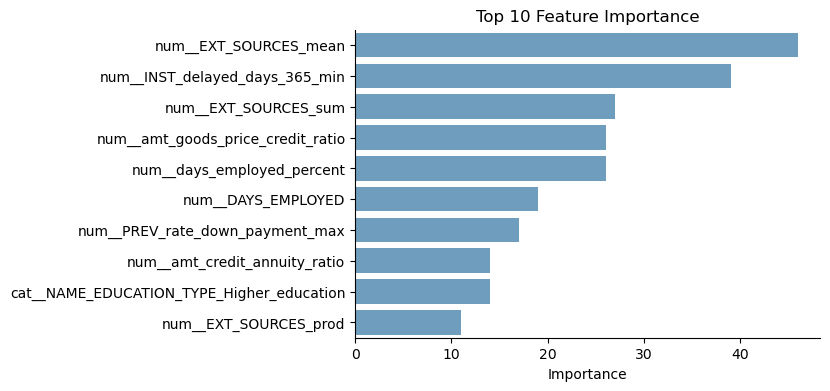

In [12]:
best_lgbm_model3 = randomized_search3.best_estimator_
model_select.plot_feature_importance(best_lgbm_model3, X_train, y_train)

Our **ROC AUC score improved only slightly from 0.2491 to 0.2524**, this result is a bit less than what I was expecting after this amount of created features.

We see that 2 of our recently engineered features made it to the **top 10** (**INST_delayed_days_365_min** and **PREV_rate_down_payment_max**), what highlights that the **delaying of payments** of a client **in the first year** of a loan is a determiner for their new applications to be a default, and also highlights the importance of the rate down payment.

Let's see how the incorporation of the Bureau dataframe will impact our results.

<h1 style="color:#774CAD">Feature Engineering - Bureau</h1>

For the **bureau data** we will compute, for each client:
- application counts,
- creating a credit active pivot table,
- financial ratios (median, max, and min values for each SK_ID_CURR).

**also part of the file feat_eng.py**.

In [13]:
df_bureau = utils.load_df(file_path="data/home-credit-default-risk/bureau.csv")

The shape of the data is: (1716428, 17)
load_df took 3.681 seconds



In [14]:
df_bureau_transf = feat_eng.BureauTransformer().fit_transform(df_bureau)
df_bureau_transf.head(3)

,SK_ID_CURR,BU_application_counts,BU_credit_active_active,BU_credit_active_bad_debt,BU_credit_active_closed,BU_credit_active_sold,AMT_CREDIT_MAX_OVERDUE_median,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_MAX_OVERDUE_min,...,BU_credit_sum_limit_ratio_max,BU_credit_sum_limit_ratio_min,BU_credit_sum_overdue_ratio_median,BU_credit_sum_overdue_ratio_mean,BU_credit_sum_overdue_ratio_max,BU_credit_sum_overdue_ratio_min,BU_limit_overdue_ratio_median,BU_limit_overdue_ratio_mean,BU_limit_overdue_ratio_max,BU_limit_overdue_ratio_min
0,100001,7,3.000,NaN,4.000,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,8,2.000,NaN,6.000,NaN,40.500,1681.029,5043.645,0.000,...,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,4,1.000,NaN,3.000,NaN,0.000,0.000,0.000,0.000,...,1.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="color:#774CAD">Pipelines and Model Run</h2>

We can now merge the recently created features to our application dataset. For that we define the next function which will also apply the feature_eng and preprocess pipeline on our data.

In [15]:
def preprocess_data(df, df_previous_transf, df_installments_transf, df_bureau_transf):
    
    df_transformed = df.merge(df_previous_transf, on="SK_ID_CURR", how="left").merge(
        df_installments_transf, on="SK_ID_CURR", how="left"
    ).merge(
        df_bureau_transf, on="SK_ID_CURR", how="left"
    )

    X = df_transformed.drop(["TARGET", "SK_ID_CURR"], axis=1)
    y = df_transformed["TARGET"]

    feat_eng_pipe2 = Pipeline(
    steps=[
        ("drop_mode_avg", feat_eng.DropModeAVG()),
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
        ('ext_sources_transformer', feat_eng.ExternalSourcesTransformer()),
        ('financial_ratio_transformer', feat_eng.FinancialRatioTransformer()),
        ('age_employment_transformer', feat_eng.AgeAndEmploymentTransformer()),
        ]
    )

    X_FE = feat_eng_pipe2.fit_transform(X)
    num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_FE)

    preprocess_pipe = pipelines.create_preprocess_pipeline(
        num_feats, binary_feats, highcard_feats
    )
    X_ready = preprocess_pipe.fit_transform(X_FE)
    X_ready = X_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

    return X_ready, y

In [16]:
X_train, y_train = preprocess_data(
    df=df_train,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    df_bureau_transf=df_bureau_transf,
)
print(X_train.shape, y_train.size)
X_train.head(3)

(153755, 324) 153755


,num__CNT_CHILDREN,num__AMT_INCOME_TOTAL,num__AMT_CREDIT,num__AMT_ANNUITY,num__AMT_GOODS_PRICE,num__REGION_POPULATION_RELATIVE,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__DAYS_REGISTRATION,num__DAYS_ID_PUBLISH,...,cat__ORGANIZATION_TYPE_Grouped_Industry_type,cat__ORGANIZATION_TYPE_Grouped_Kindergarten,cat__ORGANIZATION_TYPE_Grouped_Medicine,cat__ORGANIZATION_TYPE_Grouped_Other,cat__ORGANIZATION_TYPE_Grouped_Rare,cat__ORGANIZATION_TYPE_Grouped_School,cat__ORGANIZATION_TYPE_Grouped_Self_employed,cat__ORGANIZATION_TYPE_Grouped_Trade_type,cat__ORGANIZATION_TYPE_Grouped_Transport_type,cat__ORGANIZATION_TYPE_Grouped_XNA
0,0.000,-1.150,-0.618,-0.878,-0.612,-0.034,-0.969,-0.244,-0.605,-0.728,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.100,1.246,0.545,1.082,1.467,0.012,-0.179,-0.522,0.940,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,1.000,-0.400,1.918,0.885,2.041,-0.003,-0.368,0.441,-0.036,-0.782,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<h2 style="color:#774CAD">Applying to Model</h2>

In [17]:
randomized_search4 = randomized_search_LGBM(X_train, y_train)
randomized_search4 = randomized_search4.fit(X_train, y_train)
randomized_search4

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            learning_rate=0.01, n_estimators=10,
                                            random_state=1, verbose=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F9A14EE510>},
                   random_state=1, scoring=make_scorer(f1_score, pos_label=1))

In [18]:
lgbm_results4 = {
    'model': randomized_search4.best_estimator_,
    'best_params': randomized_search4.best_params_,
    'best_score': randomized_search4.best_score_
}

lgbm_results4

{'model': LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=9,
                n_estimators=10, random_state=1, verbose=-1),
 'best_params': {'max_depth': 9},
 'best_score': 0.25559409635375185}

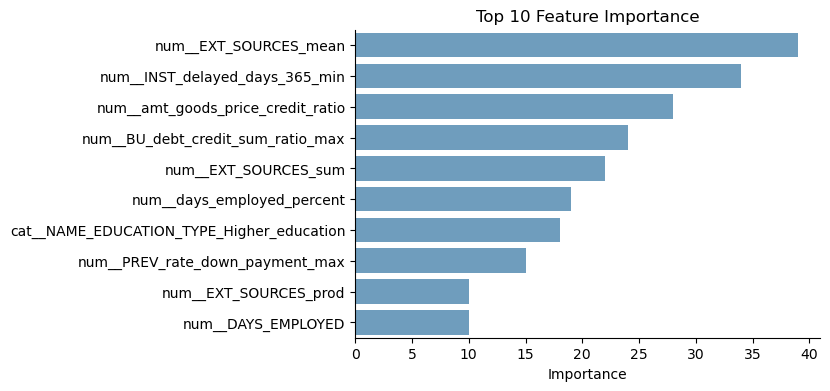

In [19]:
best_lgbm_model4 = randomized_search4.best_estimator_
model_select.plot_feature_importance(best_lgbm_model4, X_train, y_train)

The implementation of the Bureau data on our model **slightly increased the ROC AUC score to 0.2556**. Here 1 of our new feature got 4rd place of importance (**debt_credit_sum_ratio**).

We could still try to improve this score (on the same model) by adding features from the other unexplored dataframes. As the idea of this exercise is to show understanding of the Machine Learning process and how to improve ML models, we will now jump into feature selection.

<h1 style="color:#774CAD">Feature Selection</h1>

In [20]:
print(f"Our data has currently {X_train.shape[1]} features")

Our data has currently 324 features


At this stage, we have included a lot of features on our dataset, this increases the chances that our models will be focusing efforts on features that don't add much to our predictions and increases the dimensional space of our features (curse of dimensionality). Some of these features can be multicolinear as well.

We will perfom the **following steps** in this part:
- Remove features with more than 75% Null Values
- Check and remove colinear features
- Drop irrelevant features for the LGBM model

We will store the features that had some importance for our model so that we don't remove them during this process of selection

In [21]:
best_lgbm_model = randomized_search4.best_estimator_
best_lgbm_model.fit(X_train, y_train)

feature_importance = best_lgbm_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

important_feats = feature_importance_df[feature_importance_df['Importance'] != 0]["Feature"].values
important_feats.size

33

<h2 style="color:#774CAD">Missing Values</h2>

Here we chose a threshold of 75% of missing values. Some of the models that we will evaluate cannot handle missing values and we will need to perform some fill on them.

The strategy to be adopted in the modeling section is first to run the Gradient Boosting Models as they don't require the filling of NA and then go to the other models.

In [22]:
percentage_missing = (
    (X_train.isna().sum() * 100 / len(X_train))
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={0: "percentage"})
)
percentage_missing = percentage_missing[percentage_missing["percentage"] >= 75]
percentage_missing.head(10)

,index,percentage
0,num__BU_credit_active_bad_debt,99.993
1,num__BU_credit_sum_overdue_ratio_max,99.956
2,num__BU_credit_sum_overdue_ratio_mean,99.956
3,num__BU_credit_sum_overdue_ratio_median,99.946
4,num__BU_annuity_overdue_ratio_mean,99.941
5,num__BU_annuity_overdue_ratio_max,99.941
6,num__BU_annuity_overdue_ratio_median,99.939
7,num__BU_max_overdue_overdue_ratio_max,99.884
8,num__BU_max_overdue_overdue_ratio_mean,99.884
9,num__BU_max_overdue_overdue_ratio_median,99.881


We can check for the features that are on our list of important and have high null values percentage.

In [23]:
feats_missing = percentage_missing["index"].values
feature_importance_df[feature_importance_df["Feature"].isin(np.intersect1d(feats_missing, important_feats))]

,Feature,Importance


None of our important features present more than 75% null values. We proceed to drop the majoritaly null features.

In [24]:
X_train_selected = X_train.drop(feats_missing, axis=1)

<h2 style="color:#774CAD">Multicolinearity</h2>

Some of the initial multicolinear features were removed on our Feat_Eng pipeline. We will be checking now for the remaining ones and deciding on which to remove. We will perform the analysis using Persons' Correlation on the numerical features.

In [25]:
num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_train_selected)

corr_matrix = X_train_selected[num_feats].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [26]:
threshold = 0.95
correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

In [27]:
feature_importance_df[feature_importance_df["Feature"].isin(np.intersect1d(correlated_features, important_feats))]

,Feature,Importance
245,num__days_employed_percent,19
107,num__AMT_CREDIT_MAX_OVERDUE_mean,6
238,num__amt_goods_price_children_ratio,4


Some of these features present a high importance for our model and should not be dropped. Here we will **drop only the ones with no importance**.

In [28]:
correlated_features = np.setdiff1d(correlated_features, important_feats)
X_train_selected = X_train_selected.drop(correlated_features, axis=1)

<h2 style="color:#774CAD">Feature Importance</h2>

We will run our model now on the remaining features to **check for the features with null importance**. They will be dropped and that will give us our **final set of features** to be taken to our run with different models.

In [29]:
randomized_search5 = randomized_search_LGBM(X_train_selected, y_train)
randomized_search5 = randomized_search5.fit(X_train_selected, y_train)
randomized_search5

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            learning_rate=0.01, n_estimators=10,
                                            random_state=1, verbose=-1),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F9A14EE510>},
                   random_state=1, scoring=make_scorer(f1_score, pos_label=1))

In [30]:
lgbm_results5 = {
    'model': randomized_search5.best_estimator_,
    'best_params': randomized_search5.best_params_,
    'best_score': randomized_search5.best_score_
}

lgbm_results5

{'model': LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=9,
                n_estimators=10, random_state=1, verbose=-1),
 'best_params': {'max_depth': 9},
 'best_score': 0.25498859751942815}

After dropping Null vales and colinear features, our score very slightly decreased.

Let's evaluate the features that don't present any importance for this model.

In [31]:
best_lgbm_model = randomized_search5.best_estimator_
best_lgbm_model.fit(X_train_selected, y_train)

feature_importance = best_lgbm_model.feature_importances_
feature_names = X_train_selected.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

zero_importance_feats = feature_importance_df[feature_importance_df['Importance'] == 0]
print(f"The number of features with 0 importance is currently {zero_importance_feats['Feature'].count()}")

The number of features with 0 importance is currently 214


In [32]:
X_train_selected = X_train_selected.drop(zero_importance_feats["Feature"], axis=1)
print(X_train_selected.shape)
X_train_selected.head()

(153755, 33)


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_1,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__CODE_GENDER_F,cat__NAME_EDUCATION_TYPE_Higher_education
0,-0.618,-0.878,-0.969,-0.244,NaN,1.000,-1.233,-1.375,NaN,0.500,...,-0.754,-1.353,-1.848,0.000,0.056,0.642,-0.337,0.023,0.000,0.000
1,1.246,0.545,0.012,-0.179,0.300,1.000,0.061,0.152,NaN,NaN,...,0.393,-0.013,0.204,1.229,0.742,-0.671,0.269,-0.256,0.000,1.000
2,1.918,0.885,-0.368,0.441,NaN,0.000,0.027,0.046,0.197,NaN,...,-0.145,0.856,0.184,1.554,1.391,-0.125,0.721,0.542,1.000,1.000
3,0.015,0.097,0.570,1.048,1.500,0.000,-1.229,-0.488,0.819,NaN,...,-0.704,0.247,-0.437,-0.038,-0.264,-0.185,0.240,0.555,0.000,0.000
4,-0.109,-0.262,0.291,-0.531,NaN,0.000,0.114,-0.834,0.000,NaN,...,-0.442,0.436,-0.244,0.223,0.318,0.642,0.250,-0.599,1.000,0.000


As we can see, our last set present 33 features. At this point, one must think if dropping all of these features without putting them into the other models is a good idea, this was however the approach taken.

We will export those features to use in our model. In the end, I also manually dropped the remaining GENDER feature, as it was not being computed in the validation set (32 Features!!). 

In [33]:
feats_to_drop = list(set(list(feats_missing) + list(correlated_features) + list(zero_importance_feats['Feature'])))
feats_to_drop = pd.DataFrame({"Feature": feats_to_drop})
feats_to_drop.to_csv("data/feats_to_drop.csv", index=False)

In [35]:
feats_to_keep = pd.DataFrame({"Feature": X_train_selected.columns.values})
feats_to_keep = feats_to_keep[~feats_to_keep["Feature"].str.contains("GENDER")]
feats_to_keep.to_csv("data/feats_to_keep.csv", index=False)